In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [5]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/tfmodisco/models/trained_models/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "summit_prof_nll",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [6]:
print_validation_profile_and_prior_losses("SPI1_fold1")

Best profile loss overall:
	Best run: 1
	Best epoch in run: 1
	Associated value: 160.88143825848505
Best epoch in each run:
	Run 1, epoch 1: 160.88
	Run 2, epoch 1: 160.94
	Run 3, epoch 1: 160.98
All validation profile and prior losses:
1


KeyError: 'train_prof_corr_losses'

In [22]:
# For each TF and each fold, find the best model in terms of validation loss
# and record its test profile NLL and count correlation
tfs = ["CEBPB", "E2F6", "GABPA", "JUND", "REST", "SPI1", "TEAD4"]

prof_nlls, count_corrs = {}, {}
for tf in tfs:
    print("Fetching data for %s" % tf)
    prof_nlls[tf] = []
    count_corrs[tf] = []
    for fold_num in range(1, 11):
        condition = "%s_fold%d" % (tf, fold_num)
        models_path = "/users/amtseng/tfmodisco/models/trained_models/%s/" % condition
        
        prof_nlls[tf].append([])
        count_corrs[tf].append([])
        for run_num in range(1, 4):
            metrics = import_metrics_json(models_path, run_num)

            prof_nlls[tf][-1].append(np.mean(metrics["summit_prof_nll"]["values"]))
            count_corrs[tf][-1].append(np.mean(metrics["summit_count_pearson"]["values"]))

Fetching data for CEBPB
Fetching data for E2F6
Fetching data for GABPA
Fetching data for JUND
Fetching data for REST
Fetching data for SPI1
Fetching data for TEAD4


In [74]:
def plot_fold_consistency(tf_data_dict, ylabel):
    fig, ax = plt.subplots(len(tfs), 1, figsize=(10, 20), sharex=True, sharey=True)
    for i, tf in enumerate(tfs):
        xvals, yvals = [], []
        for j, vals in enumerate(tf_data_dict[tf]):
            xvals.extend([j + 1] * len(vals))
            yvals.extend(vals)
        ax[i].scatter(xvals, yvals)
        ax[i].set_title(tf, fontsize=16)
    plt.xlabel("Fold", fontsize=14)
    plt.xticks(range(1, 11))
    fig.text(0.06, 0.5, ylabel, ha="center", va="center", rotation="vertical", fontsize=14)
    fig.suptitle("Consistency of " + ylabel + " across folds", fontsize=16)

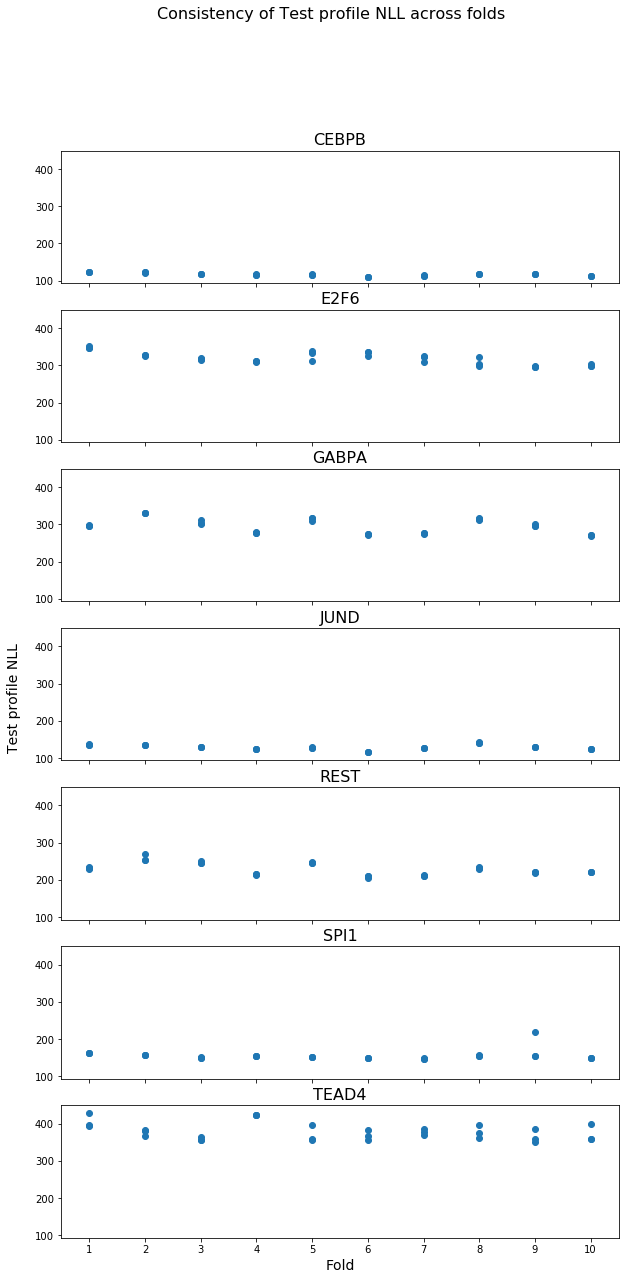

In [75]:
plot_fold_consistency(prof_nlls, "Test profile NLL")

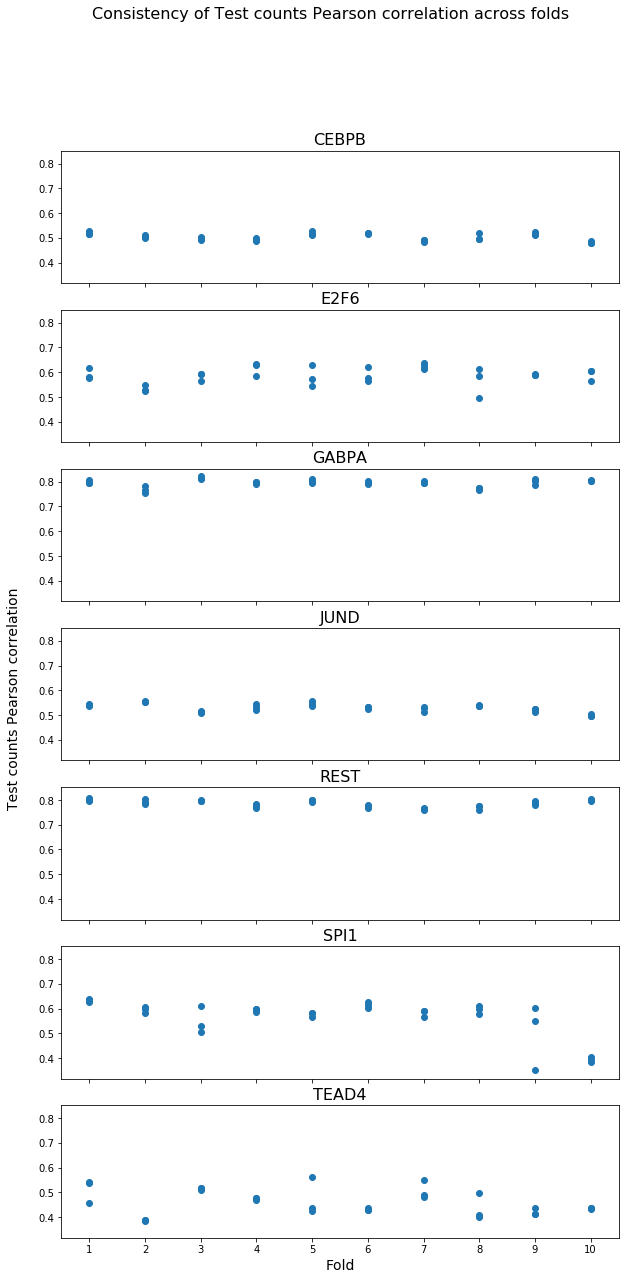

In [76]:
plot_fold_consistency(count_corrs, "Test counts Pearson correlation")